In [1]:
#importing the required files

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

print('Modules imported!')

Modules imported!


In [2]:
#setting the data

dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
rides = pd.read_csv('data/wind_data.csv', parse_dates = [0], index_col = 'DATE (MM/DD/YYYY)', date_parser = dateparse)
data = pd.read_csv('data/wind_data.csv')
data.head()

,DATE (MM/DD/YYYY),HOUR-MST,Avg Temperature @ 50m [deg C],Avg Wind Chill Temp [deg C],Avg Dew Point Temp [deg C],Avg Relative Humidity [%],Avg Specific Humidity [g/Kg],Avg Station Pressure [mBar],Avg Sea-Level Pressure (Est) [mBar],Avg Atmospheric Electric Field [kV/m],Avg Avg Wind Speed @ 50m [m/s],Avg Avg Wind Shear [1/s],Avg Friction Velocity (u*) [m/s],Avg Est Surface Roughness [m]
0,1/1/2015,1,-6.8523,-17.4381,-17.5501,60.3718,0.9938,813.2682,1017.9600,-99999.0,3.8032,0.0588,0.3084,0.1491
1,1/1/2015,2,-7.1717,-16.4592,-17.0799,59.0476,1.0398,812.6947,1017.2650,-99999.0,3.7096,0.0757,0.3698,0.1602
2,1/1/2015,3,-7.3151,-13.5495,-15.9034,62.3790,1.1632,812.0688,1016.5117,-99999.0,2.4968,0.0319,0.2250,0.2649
3,1/1/2015,4,-7.8468,-12.6394,-15.0834,63.2333,1.2544,811.5503,1015.8933,-99999.0,3.7711,0.0476,0.2973,0.4295
4,1/1/2015,5,-7.7747,-12.1157,-15.1327,63.9393,1.2493,811.2588,1015.5383,-99999.0,1.8259,0.0157,0.1643,0.7667


In [3]:
#dropping unnessary data

fields_to_drop = ['Avg Atmospheric Electric Field [kV/m]', 'DATE (MM/DD/YYYY)']
rides = rides.drop(fields_to_drop[0], axis = 1)
data = data.drop(fields_to_drop, axis = 1)
data.head()

,HOUR-MST,Avg Temperature @ 50m [deg C],Avg Wind Chill Temp [deg C],Avg Dew Point Temp [deg C],Avg Relative Humidity [%],Avg Specific Humidity [g/Kg],Avg Station Pressure [mBar],Avg Sea-Level Pressure (Est) [mBar],Avg Avg Wind Speed @ 50m [m/s],Avg Avg Wind Shear [1/s],Avg Friction Velocity (u*) [m/s],Avg Est Surface Roughness [m]
0,1,-6.8523,-17.4381,-17.5501,60.3718,0.9938,813.2682,1017.9600,3.8032,0.0588,0.3084,0.1491
1,2,-7.1717,-16.4592,-17.0799,59.0476,1.0398,812.6947,1017.2650,3.7096,0.0757,0.3698,0.1602
2,3,-7.3151,-13.5495,-15.9034,62.3790,1.1632,812.0688,1016.5117,2.4968,0.0319,0.2250,0.2649
3,4,-7.8468,-12.6394,-15.0834,63.2333,1.2544,811.5503,1015.8933,3.7711,0.0476,0.2973,0.4295
4,5,-7.7747,-12.1157,-15.1327,63.9393,1.2493,811.2588,1015.5383,1.8259,0.0157,0.1643,0.7667


In [4]:
#making settlement date as the index for the ts data

ts = rides['Avg Avg Wind Speed @ 50m [m/s]']
ts.head(10)


DATE (MM/DD/YYYY)
2015-01-01    3.8032
2015-01-01    3.7096
2015-01-01    2.4968
2015-01-01    3.7711
2015-01-01    1.8259
2015-01-01    2.4815
2015-01-01    1.0171
2015-01-01    2.0922
2015-01-01    4.6892
2015-01-01    3.8240
Name: Avg Avg Wind Speed @ 50m [m/s], dtype: float64

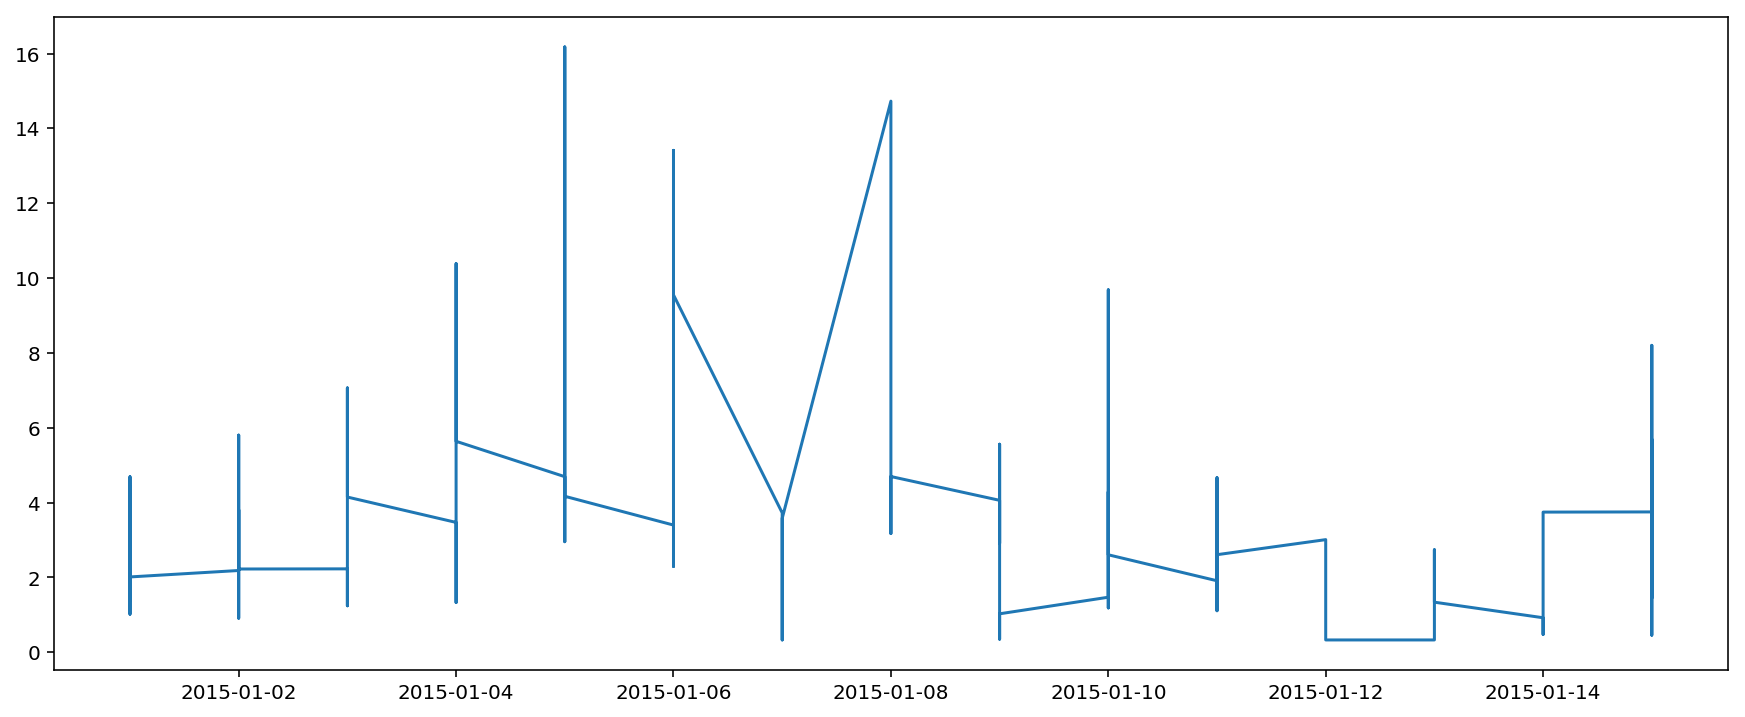

In [5]:
#line plot

plt.plot(ts['1/1/2015':'1/15/2015'])

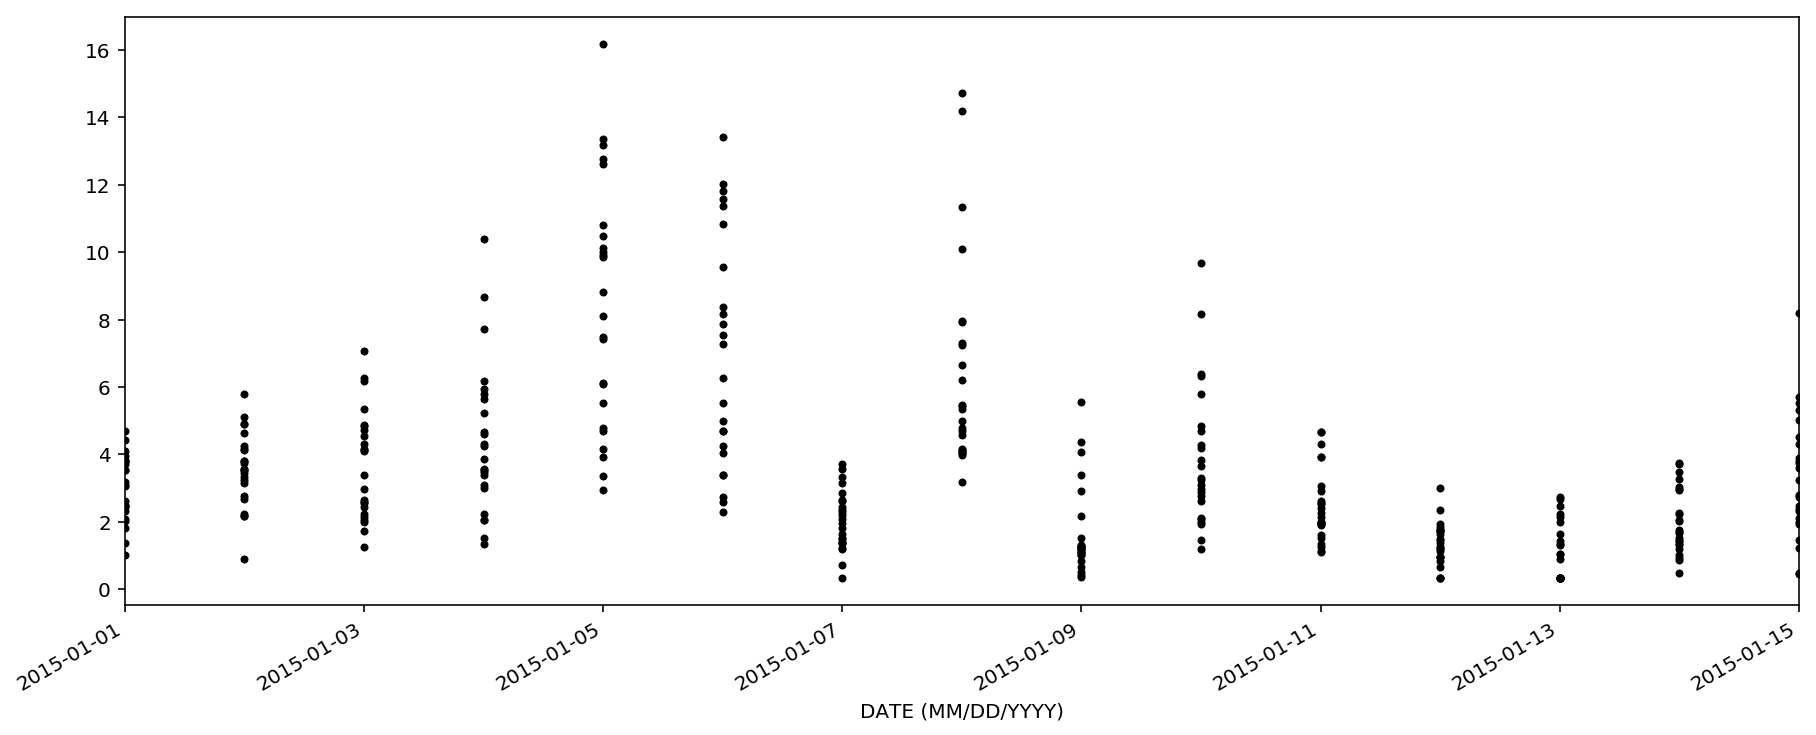

In [6]:
#black dots visualization of the data

ts['1/1/2015':'1/15/2015'].plot(style='k.')


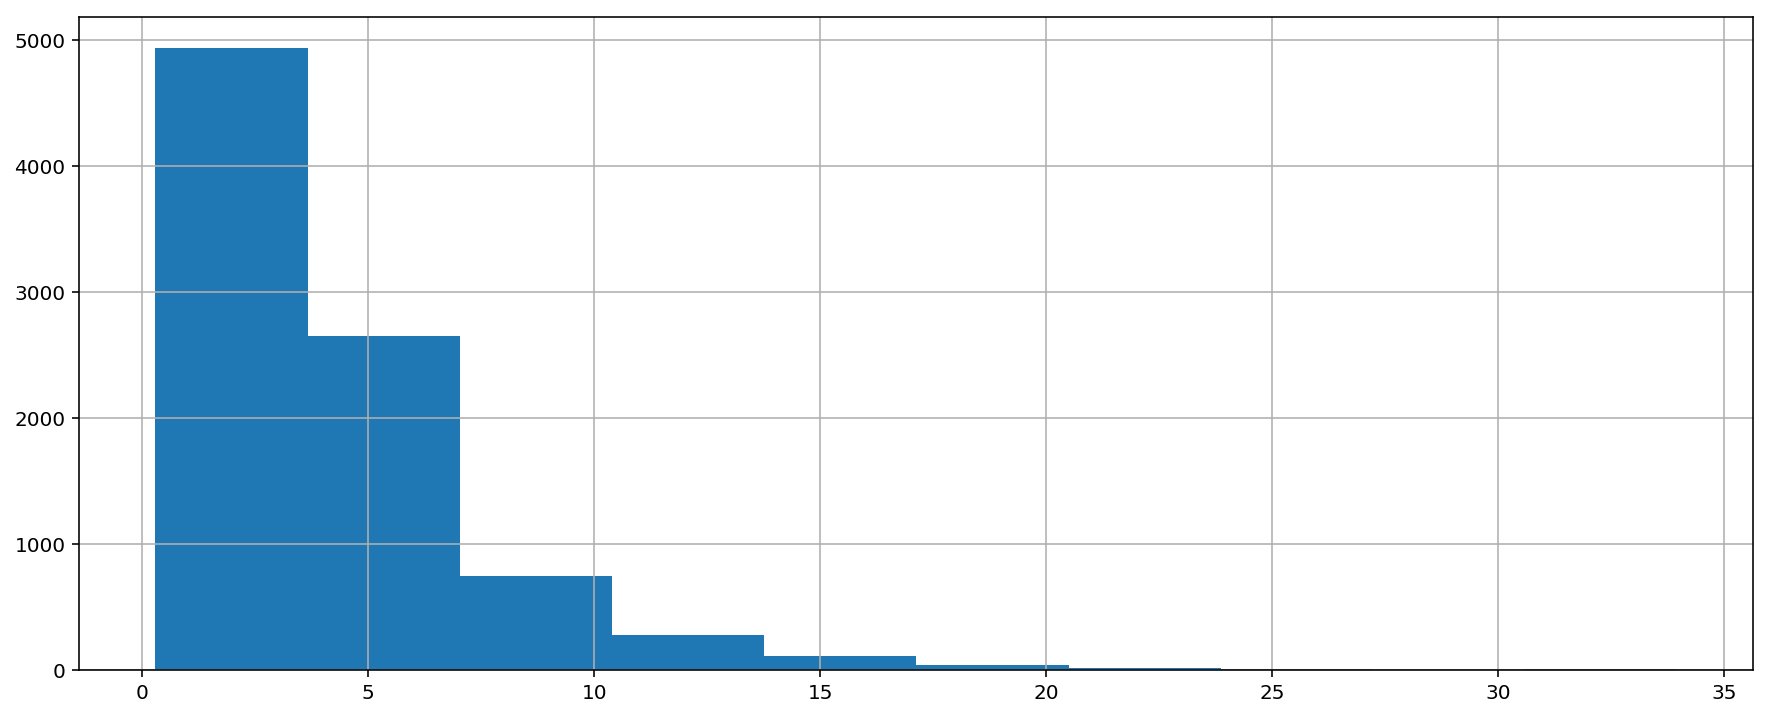

In [7]:
#histogram plot of the data

ts.hist()

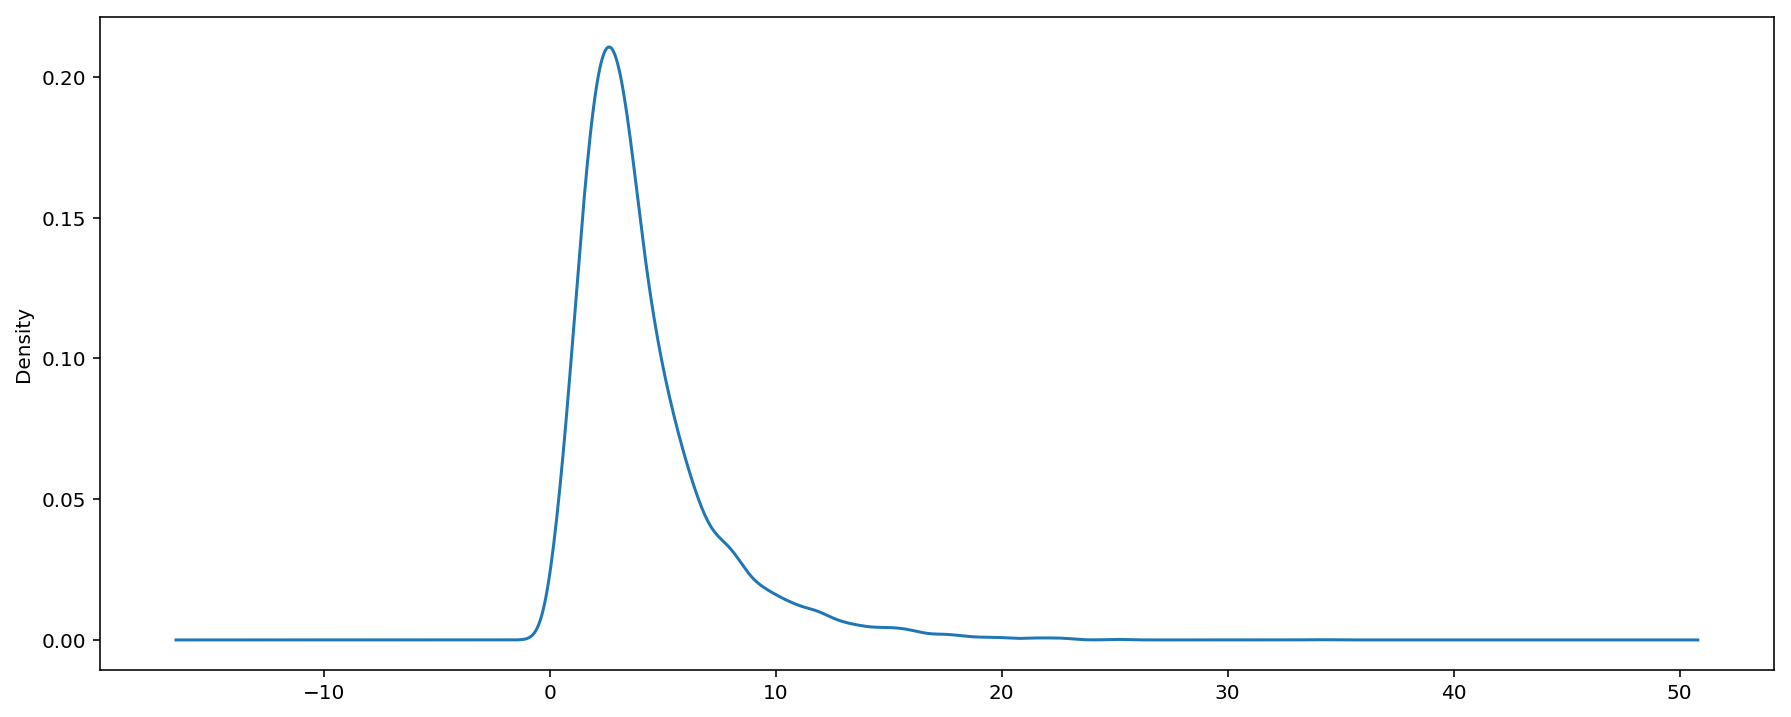

In [8]:
#smooth line used for the histogram like plot

ts.plot(kind='kde')

In [9]:
#normalizing of input data

quant_features = ['Avg Temperature @ 50m [deg C]', 'Avg Wind Chill Temp [deg C]', 'Avg Dew Point Temp [deg C]', 'Avg Relative Humidity [%]', 'Avg Specific Humidity [g/Kg]', 'Avg Station Pressure [mBar]', 'Avg Sea-Level Pressure (Est) [mBar]', 'Avg Avg Wind Speed @ 50m [m/s]', 'Avg Avg Wind Shear [1/s]', 'Avg Friction Velocity (u*) [m/s]', 'Avg Est Surface Roughness [m]']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
    
print('Normalization Successful!')

Normalization Successful!


In [10]:
data.head()

,HOUR-MST,Avg Temperature @ 50m [deg C],Avg Wind Chill Temp [deg C],Avg Dew Point Temp [deg C],Avg Relative Humidity [%],Avg Specific Humidity [g/Kg],Avg Station Pressure [mBar],Avg Sea-Level Pressure (Est) [mBar],Avg Avg Wind Speed @ 50m [m/s],Avg Avg Wind Shear [1/s],Avg Friction Velocity (u*) [m/s],Avg Est Surface Roughness [m]
0,1,0.013005,-2.474723,-2.206503,0.174601,-1.437976,-0.221405,-0.220537,-0.116255,0.100900,-0.032263,0.010099
1,2,0.012856,-2.384872,-2.148675,0.125363,-1.423202,-0.332941,-0.333197,-0.146500,0.509612,0.019063,0.010109
2,3,0.012788,-2.117795,-2.003983,0.249236,-1.383569,-0.454668,-0.455307,-0.538386,-0.549653,-0.101980,0.010207
3,4,0.012540,-2.034259,-1.903135,0.281002,-1.354278,-0.555507,-0.555550,-0.126628,-0.169962,-0.041542,0.010361
4,5,0.012573,-1.986189,-1.909198,0.307253,-1.355916,-0.612199,-0.613095,-0.755170,-0.941437,-0.152721,0.010677


In [11]:
#dividing data into training, validation and test data

test_data = data[-60*48:]
data = data[:-60*48]

target_fields = ['Avg Avg Wind Speed @ 50m [m/s]']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.7), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

print('Dividing data into training, validation and testing successful!')

Dividing data into training, validation and testing successful!


In [18]:
#code for rvfl network

#activation functions
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0, x)
    
def tanh(x):
    return np.tanh(x)

def sine(x):
    return np.sin(x)
    
class NeuralNetwork:
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        
        self.learning_rate = learning_rate
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        #activation function on the outputs of hidden layer
        #self.activation_function = sigmoid
        #self.activation_function = relu
        self.activation_function = tanh
        #self.activation_function = sine
        
        #range of the random weights for input to hidden neurons
        self.weights_input_to_hidden = np.random.uniform(-0.5, 0.5,(self.hidden_nodes, self.input_nodes))
        #self.weights_input_to_hidden = np.random.uniform(0.0, 1.0,(self.hidden_nodes, self.input_nodes))
        #self.weights_input_to_hidden = np.random.uniform(-1.5, 1.5,(self.hidden_nodes, self.input_nodes))
        #self.weights_input_to_hidden = np.random.uniform(-2.0, 2.0,(self.hidden_nodes, self.input_nodes))
        
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5,(self.output_nodes, self.hidden_nodes)) 
        self.biases_output = np.random.normal(0.5, 1.0,(self.output_nodes)) 
        self.weights_input_to_output = np.random.normal(0.0, self.output_nodes**-0.5, (self.output_nodes, self.input_nodes))
    
    def train(self, inputs_list, targets_list):
        
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        #forward pass
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) + np.dot(self.weights_input_to_output, inputs) + self.biases_output
        final_outputs = final_inputs
        
        #backward pass
        output_errors = (targets - final_outputs) + (5.0 * np.sum(self.weights_hidden_to_output))/self.weights_hidden_to_output.size
        self.weights_hidden_to_output += self.learning_rate * np.dot(output_errors, hidden_outputs.T)
        self.weights_input_to_output += self.learning_rate * np.dot(output_errors, inputs.T)
        self.biases_output += output_errors[0][0] * self.learning_rate
        
    def run(self, inputs_list):
        
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) + np.dot(self.weights_input_to_output, inputs) + self.biases_output
        final_outputs = final_inputs
        return final_outputs

print('RVFL created!')

RVFL created!


In [19]:
#errors for analyzing the performance of our network on testing data set
def MSE(y, Y):
    return np.mean((y-Y)**2)

def RMSE(y, Y):
    return (np.mean((y-Y)**2))**0.5

def nRMSE(y, Y):
    return ((np.mean((y-Y)**2))**0.5)/np.std(Y)

In [23]:
#training the network

epochs = 1000
learning_rate = 0.00005

#varying number of hidden nodes
hidden_nodes = 20
#hidden_nodes = 15
#hidden_nodes = 20

output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, train_targets.ix[batch]['Avg Avg Wind Speed @ 50m [m/s]']):
        network.train(record, target)
    if e%(epochs/10) == 0:
        
        train_loss = MSE(network.run(train_features), train_targets['Avg Avg Wind Speed @ 50m [m/s]'].values)
        val_loss = MSE(network.run(val_features), val_targets['Avg Avg Wind Speed @ 50m [m/s]'].values)
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        print('Training MSE loss: {:.4f}'.format(train_loss))
        print('Validation MSE loss: {:.4f}'.format(val_loss))

Training MSE loss: 18.7393
Validation MSE loss: 14.9559
Training MSE loss: 4.2257
Validation MSE loss: 4.2178
Training MSE loss: 0.9681
Validation MSE loss: 0.9683
Training MSE loss: 0.4835
Validation MSE loss: 0.4723
Training MSE loss: 0.3602
Validation MSE loss: 0.3516
Training MSE loss: 0.3358
Validation MSE loss: 0.3285
Training MSE loss: 0.3216
Validation MSE loss: 0.3135
Training MSE loss: 0.3058
Validation MSE loss: 0.2964
Training MSE loss: 0.2719
Validation MSE loss: 0.2617
Training MSE loss: 0.2720
Validation MSE loss: 0.2616


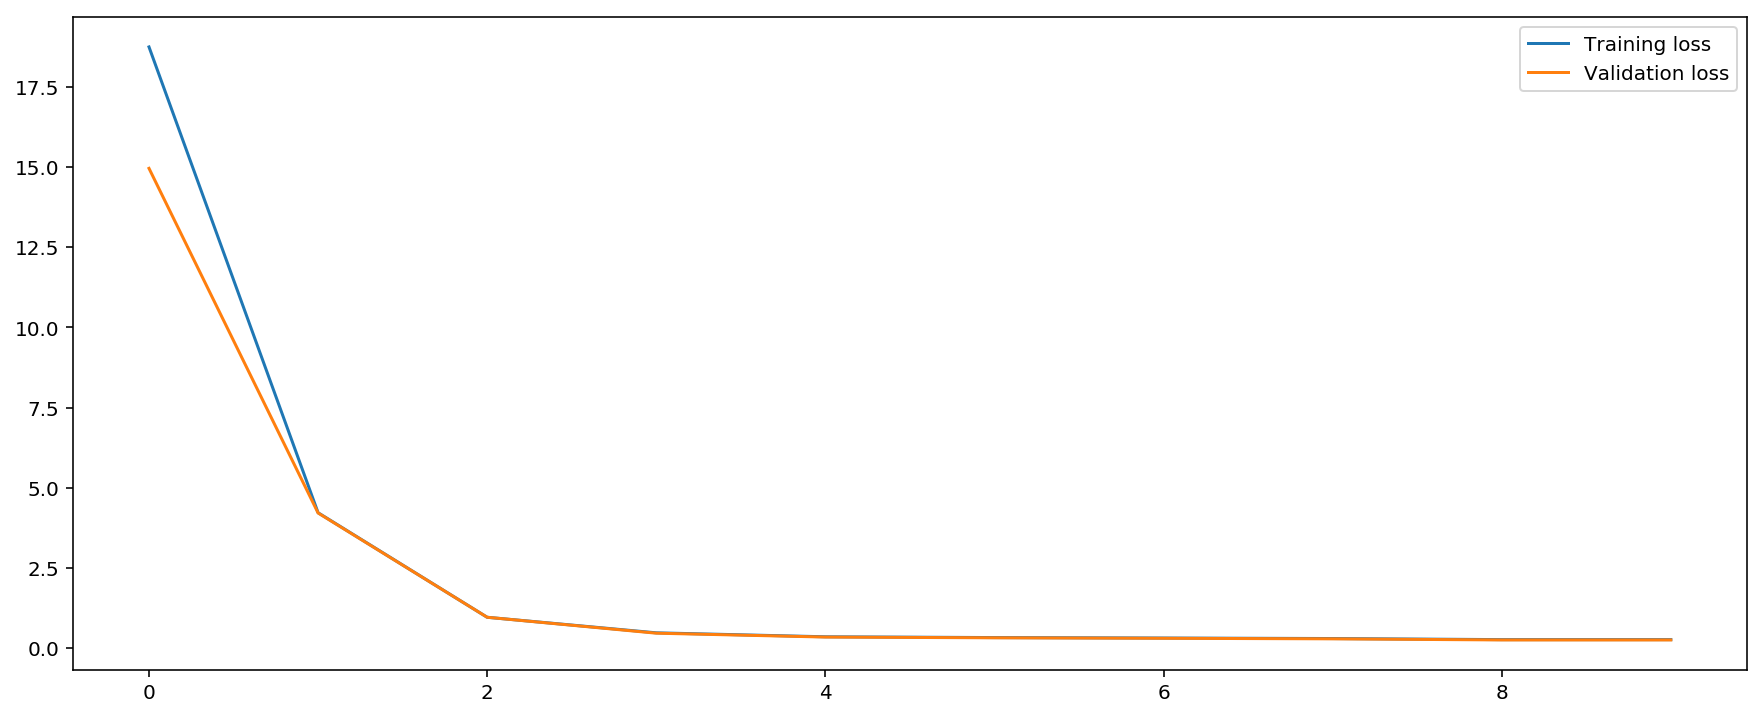

In [24]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

In [25]:
#testing losses
print('')
print('Performance on Test Data:')
print('')
test_mse_loss = MSE(network.run(test_features), test_targets['Avg Avg Wind Speed @ 50m [m/s]'].values)
print('Testing MSE loss: {:.4f}'.format(test_mse_loss))
test_rmse_loss = RMSE(test_targets['Avg Avg Wind Speed @ 50m [m/s]'].values, network.run(test_features))
print('Testing RMSE loss: {:.4f}'.format(test_rmse_loss))
test_nrmse_loss = nRMSE(network.run(test_features), test_targets['Avg Avg Wind Speed @ 50m [m/s]'].values)
print('Testing nRMSE loss: {:.4f}'.format(test_nrmse_loss))


Performance on Test Data:

Testing MSE loss: 0.3229
Testing RMSE loss: 0.5682
Testing nRMSE loss: 0.4863
